# This notebook is used to visualy inspect the quality of the ground truths and the proposed regions of interest RoI for the masked R-CNN

In [ ]:
dataset_filepath = "/net/vdesk/data2/penchev/project_data/inspect-pipeline/"
dataset_split = "train" # Change to "val" or "test" as needed
images_train_filepath = "images"
proposals_train_filepath = "proposals"
annotations_path = "annotations.json"

# Load the json file containing the cutout metadata and proposed RoIs

In [2]:
import json
import os

annotations_path = os.path.join(dataset_filepath, dataset_split, annotations_path)
with open(annotations_path, "r") as f:
    annotations = json.load(f)

# Show the structure of the annotations (COCO format)
for key in annotations.keys():
    key_type = type(annotations[key])
    element_type = type(annotations[key][0]) if isinstance(annotations[key], list) and len(annotations[key]) > 0 else None
    print(f"{key}: {key_type}, element type: {element_type}, length: {len(annotations[key])}")
    if element_type == dict:
        for key2 in annotations[key][0].keys():
            key2_type = type(annotations[key][0][key2])
            element2_type = type(annotations[key][0][key2][0]) if isinstance(annotations[key][0][key2], list) and len(annotations[key][0][key2]) > 0 else None
            print(f"  {key2}: {key2_type}")
            if key2 == "metadata":
                for key3 in annotations[key][0][key2].keys():
                    key3_type = type(annotations[key][0][key2][key3])
                    print(f"    {key3}: {key3_type}")

images: <class 'list'>, element type: <class 'dict'>, length: 56
  id: <class 'int'>
  file_name: <class 'str'>
  width: <class 'int'>
  height: <class 'int'>
  metadata: <class 'dict'>
    RA: <class 'float'>
    DEC: <class 'float'>
    grg_positions: <class 'list'>
    all_component_positions: <class 'list'>
    rotated: <class 'bool'>
    rotation_angle: <class 'int'>
    stretch: <class 'str'>
    reprojected: <class 'bool'>
    old_redshift: <class 'NoneType'>
    new_redshift: <class 'NoneType'>
annotations: <class 'list'>, element type: <class 'dict'>, length: 56
  id: <class 'int'>
  image_id: <class 'int'>
  category_id: <class 'int'>
  bbox: <class 'list'>
  area: <class 'float'>
  segmentation: <class 'list'>
  iscrowd: <class 'int'>
categories: <class 'list'>, element type: <class 'dict'>, length: 1
  id: <class 'int'>
  name: <class 'str'>


In [3]:
def get_image_by_id(annotations: dict, image_id: int) -> dict:
    """
    Retrieve the image element from the annotations JSON by image ID.
    
    :param annotations: The annotations dictionary containing 'images' list
    :param image_id: The ID of the image to find
    :return: Dictionary containing image metadata (id, file_name, width, height, metadata)
    :raises ValueError: If image_id is not found
    """
    for image in annotations['images']:
        if image['id'] == image_id:
            return image
    raise ValueError(f"Image with id {image_id} not found in annotations")

In [4]:
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import numpy as np
import os

def plot_image_with_boxes_proposals(annotations: dict, annotations_path: str, id: int):
    """
    Plot an image with bounding boxes overlaid.
    
    :param image_path: Path to the image file
    :param boxes: Array of bounding boxes in the format [x_min, y_min, x_max, y_max]
    """
    image_info = get_image_by_id(annotations, id)
    image_file_name = image_info['file_name']
    proposals = image_file_name.replace(".png", ".npz")
    image_path = os.path.join(dataset_filepath, dataset_split, images_train_filepath, image_file_name)
    proposals_path = os.path.join(dataset_filepath, dataset_split, proposals_train_filepath, proposals)

    # Get the data for the plotting of the images
    proposal_boxes = np.load(proposals_path)['boxes']
    print(f"First proposal box (raw): {proposal_boxes[0]}")
    print(f"Proposal box shape: {proposal_boxes.shape}")

    # Load COCO annotations
    coco = COCO(annotations_path)
    ann_ids = coco.getAnnIds(imgIds=[id], iscrowd=None)
    anns = coco.loadAnns(ann_ids)
    
    # COCO format: [x_min, y_min, x_max, y_max]
    # (x_min, y_min) is the top-left corner
    # (x_max, y_max) is the bottom-right corner
    gt_boxes = [ann['bbox'] for ann in anns]
    
    # Get segmentation masks
    segs = [ann['segmentation'] for ann in anns]
    
    # Get component positions
    grg_positions = image_info['metadata'].get('grg_positions', [])
    all_component_positions = image_info['metadata'].get('all_component_positions', [])
    
    # Exclude GRG positions from all component positions
    comp_positions = [pos for pos in all_component_positions if pos not in grg_positions]
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    img = plt.imread(image_path)
    
    # Plot GT boxes and segmentation on ax[0]
    ax[0].imshow(img)
    for box in gt_boxes:
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        rect = plt.Rectangle((x_min, y_min), width, height, edgecolor='blue', facecolor='none', linewidth=2)
        ax[0].add_patch(rect)
    for seg in segs:
        if isinstance(seg, list):  # Polygon segmentation
            for polygon in seg:
                poly = np.array(polygon).reshape((-1, 2))
                ax[0].fill(poly[:, 0], poly[:, 1], alpha=0.3, color='black')
    for pos in grg_positions:
        x, y = pos
        ax[0].scatter(x, y, c='yellow', s=10)
        ax[0].annotate(f"({x:.1f}, {y:.1f})", (x, y), textcoords="offset points", xytext=(0,5), ha='center', color='yellow', fontsize=8)
    for pos in comp_positions:
        x, y = pos
        ax[0].scatter(x, y, c='cyan', s=10)
        ax[0].annotate(f"({x:.1f}, {y:.1f})", (x, y), textcoords="offset points", xytext=(0,5), ha='center', color='cyan', fontsize=8)
    
    ax[0].set_title("GT Boxes and Segmentation")

    ax[1].imshow(img)
    print(f"Plotting {len(proposal_boxes)} proposal boxes on image {image_file_name}")

    # First find the box with the biggest overlap with GT boxes
    iou_scores = []
    gt_x_min, gt_y_min, gt_x_max, gt_y_max = gt_boxes[0]  # Assuming one GT box for simplicity
    gt_width = gt_x_max - gt_x_min
    gt_height = gt_y_max - gt_y_min
    gt_box_area = gt_width * gt_height
    # assert gt_width > 0, "GT box has non-positive width"
    # assert gt_height > 0, "GT box has non-positive height"
    for box in proposal_boxes:
        # Get the proposal box coordinates
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min

        # Calculate intersection
        inter_x_min = max(x_min, gt_x_min)
        inter_y_min = max(y_min, gt_y_min)
        inter_x_max = min(x_max, gt_x_max)
        inter_y_max = min(y_max, gt_y_max)
        inter_width = max(0, inter_x_max - inter_x_min)
        inter_height = max(0, inter_y_max - inter_y_min)
        intersection = inter_width * inter_height

        # Calculate union
        box_area = width * height
        union = box_area + gt_box_area - intersection
        iou = intersection / union if union > 0 else 0

        iou_scores.append(iou)

    iou_scores_arr = np.array(iou_scores)
    best_box_idx = np.argmax(iou_scores_arr)
    print(f"Best box index: {best_box_idx}, IoU: {iou_scores_arr[best_box_idx]:.4f}")

    for i, box in enumerate(proposal_boxes):
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        rect = plt.Rectangle((x_min, y_min), width, height, edgecolor='red', facecolor='none', linewidth=2, label='Proposed Box' if i == 0 else "")
        ax[1].add_patch(rect)

    # Plot the best box in green
    best_box = proposal_boxes[best_box_idx]
    x_min, y_min, x_max, y_max = best_box
    width = x_max - x_min
    height = y_max - y_min
    rect = plt.Rectangle((x_min, y_min), width, height, edgecolor='green', facecolor='none', linewidth=2, label='Best Box')
    ax[1].add_patch(rect)

    ax[1].set_title("Image with Bounding Boxes")
    plt.legend()
    plt.show()

First proposal box (raw): [152. 159. 168. 173.]
Proposal box shape: (511, 4)
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Plotting 511 proposal boxes on image LoTSS_GRG_0000000009_RA25.153356_DEC18.92208389051.png
Best box index: 3, IoU: 1.0000


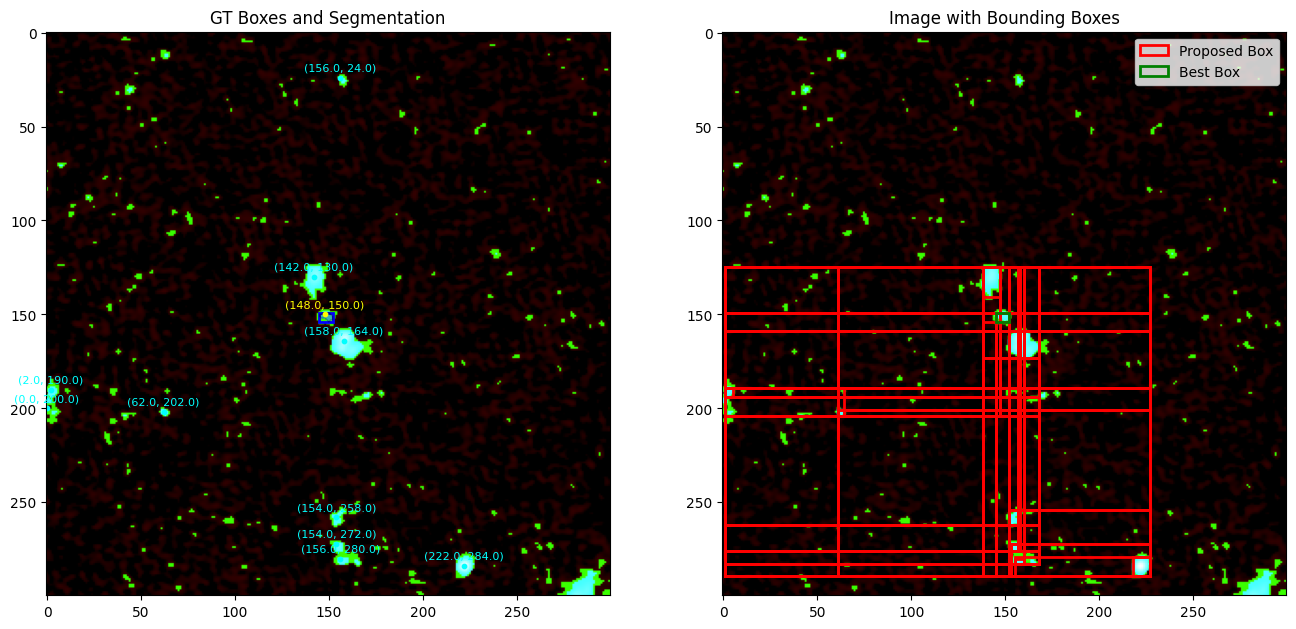

First proposal box (raw): [288. 257. 299. 274.]
Proposal box shape: (1023, 4)
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Plotting 1023 proposal boxes on image LoTSS_GRG_0000000010_rotated_angle45_RA25.153356_DEC18.92208389051.png
Best box index: 5, IoU: 1.0000


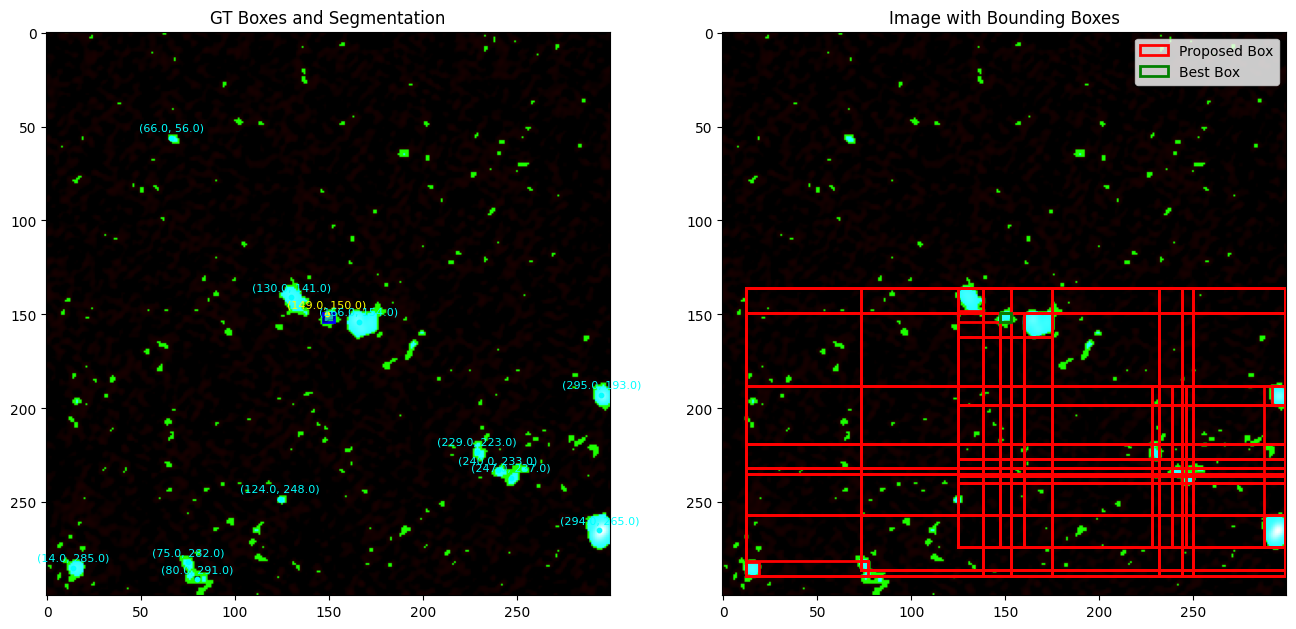

First proposal box (raw): [159. 132. 173. 148.]
Proposal box shape: (511, 4)
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Plotting 511 proposal boxes on image LoTSS_GRG_0000000011_rotated_angle90_RA25.153356_DEC18.92208389051.png
Best box index: 3, IoU: 1.0000


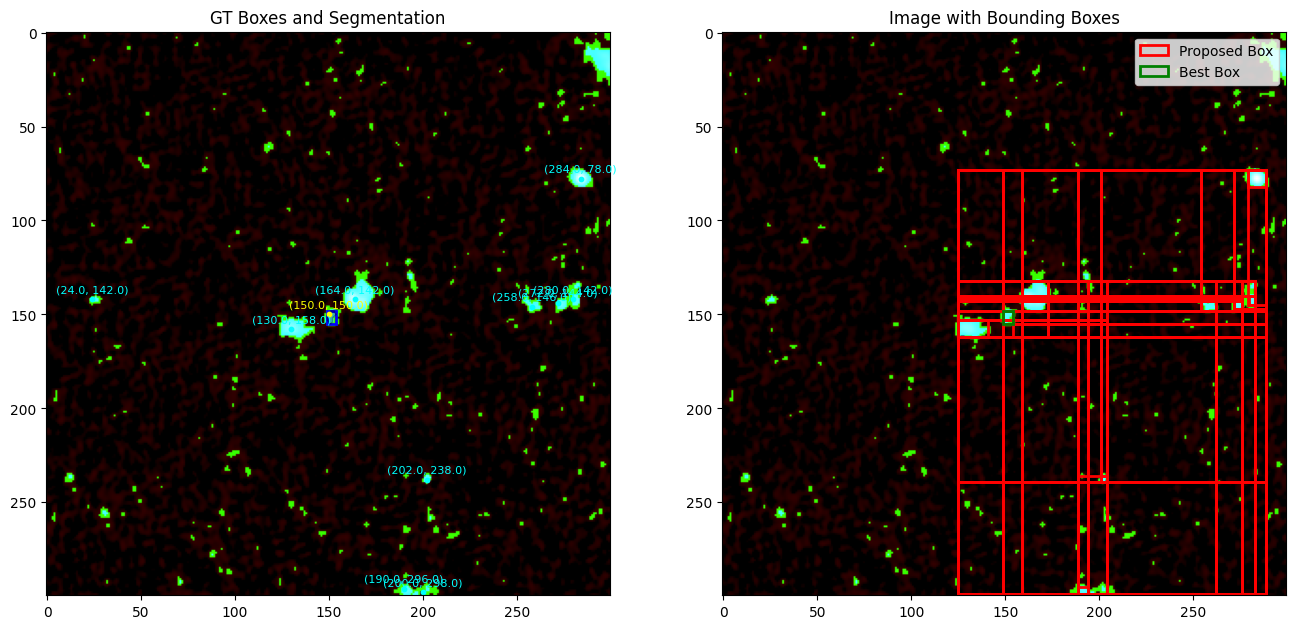

First proposal box (raw): [257.   0. 274.  12.]
Proposal box shape: (1023, 4)
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Plotting 1023 proposal boxes on image LoTSS_GRG_0000000012_rotated_angle135_RA25.153356_DEC18.92208389051.png
Best box index: 5, IoU: 1.0000


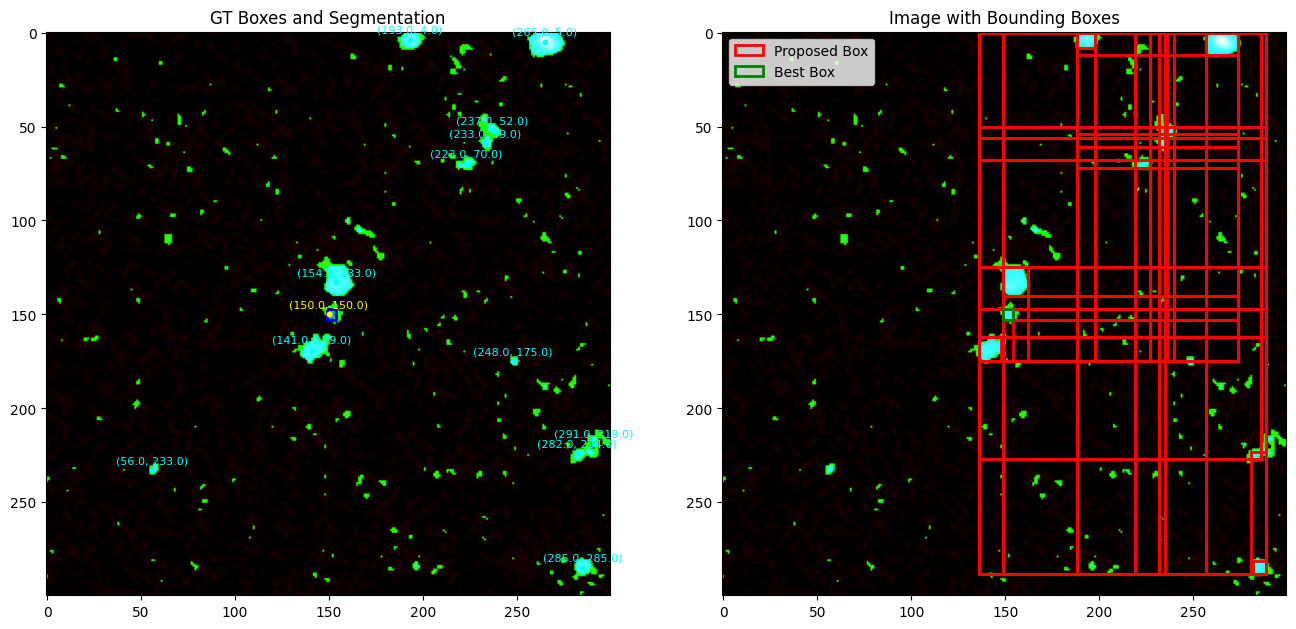

First proposal box (raw): [132. 127. 148. 141.]
Proposal box shape: (1023, 4)
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Plotting 1023 proposal boxes on image LoTSS_GRG_0000000013_rotated_angle180_RA25.153356_DEC18.92208389051.png
Best box index: 3, IoU: 1.0000


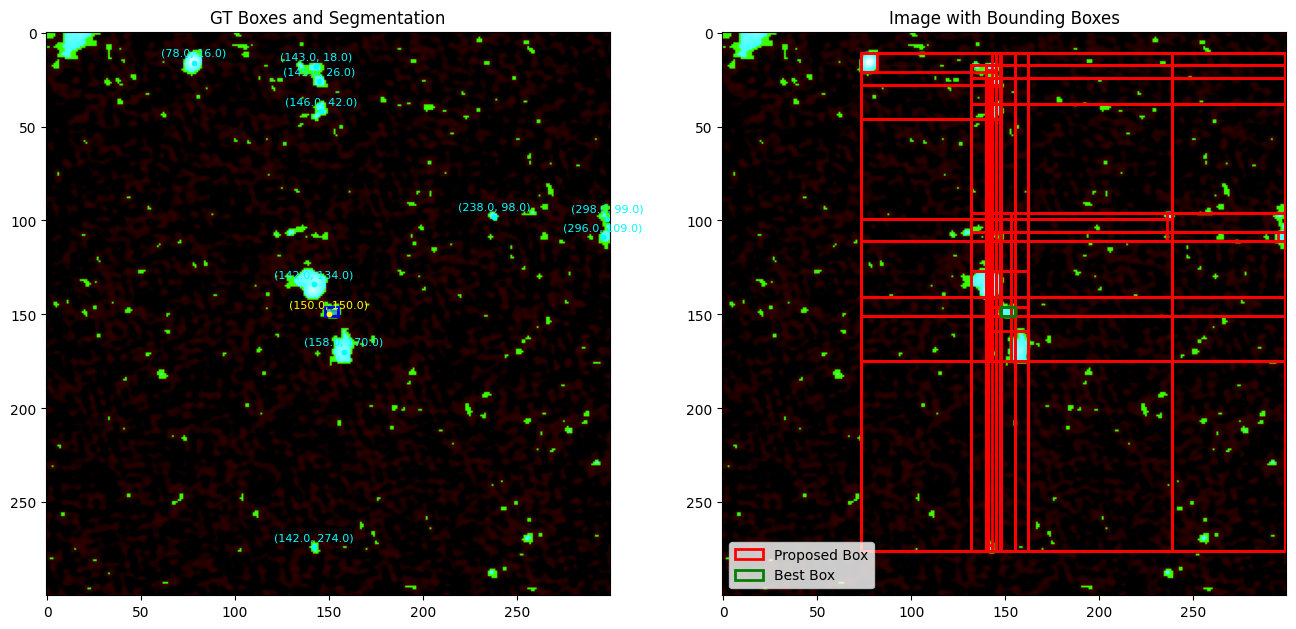

First proposal box (raw): [ 0. 26. 12. 43.]
Proposal box shape: (1023, 4)
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Plotting 1023 proposal boxes on image LoTSS_GRG_0000000014_rotated_angle225_RA25.153356_DEC18.92208389051.png
Best box index: 5, IoU: 1.0000


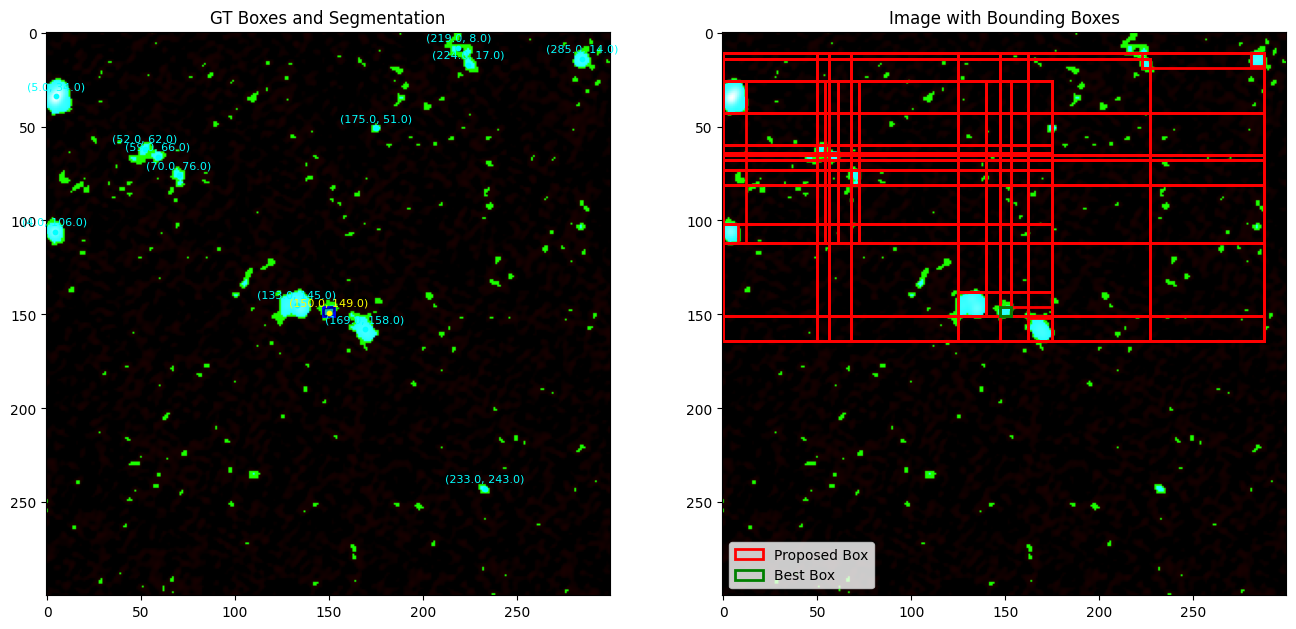

First proposal box (raw): [127. 152. 141. 168.]
Proposal box shape: (1023, 4)
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Plotting 1023 proposal boxes on image LoTSS_GRG_0000000015_rotated_angle270_RA25.153356_DEC18.92208389051.png
Best box index: 3, IoU: 1.0000


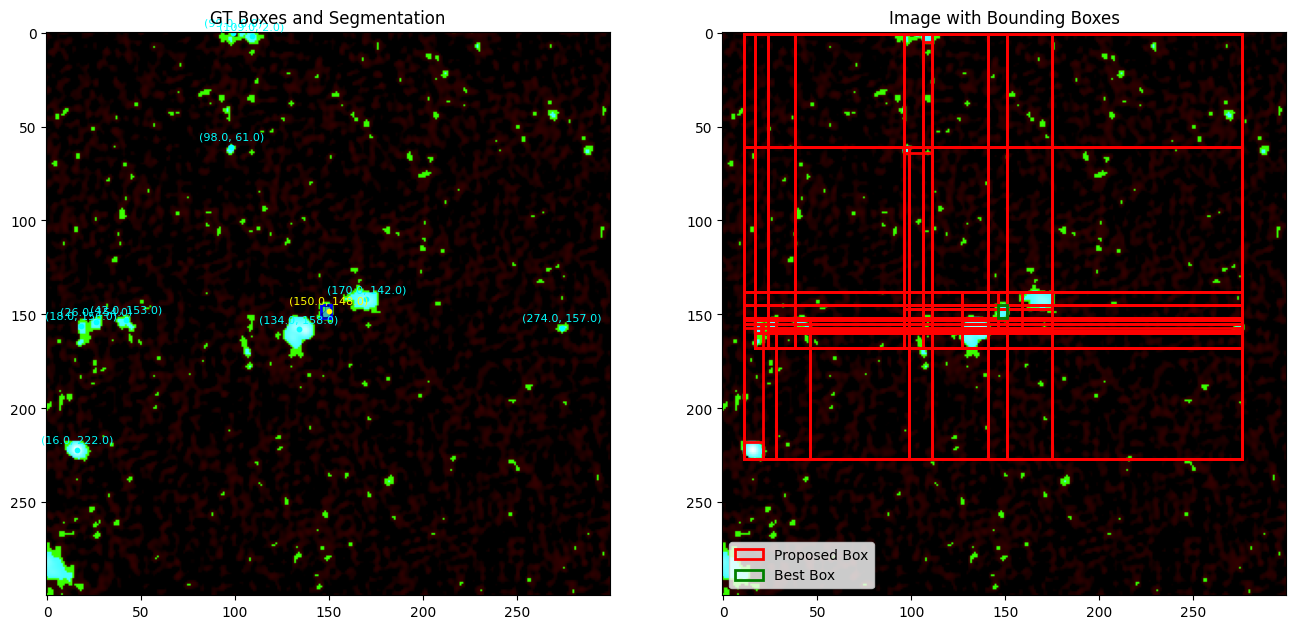

First proposal box (raw): [ 26. 288.  43. 299.]
Proposal box shape: (1023, 4)
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Plotting 1023 proposal boxes on image LoTSS_GRG_0000000016_rotated_angle315_RA25.153356_DEC18.92208389051.png
Best box index: 5, IoU: 1.0000


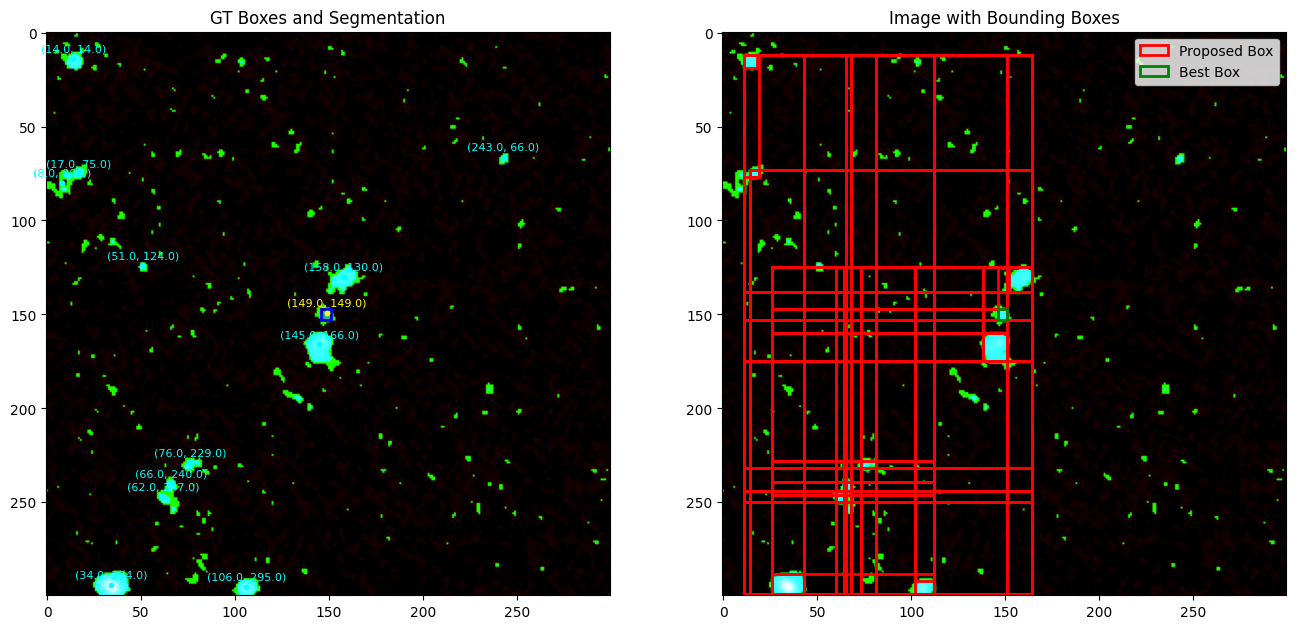

In [5]:
start_id = 1 + 8
for i in range(start_id, start_id + 8):
    plot_image_with_boxes_proposals(annotations, annotations_path, i)